In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
import pandas as pd
%matplotlib inline

In [2]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return a*x + b

def wrapRad(theta):
#     return theta % (2*np.pi)
    return (theta + np.pi) % (2*np.pi) - np.pi

$$\vec{e_1} = e_1 e^{i\varpi_1}$$
$$\tilde{\vec{e_{1}}} = \vec{e_1}-\vec{e}, \qquad \tilde{\vec{e_{2}}} = \vec{e_2}-\vec{e}$$

In [75]:
def sim(P1, P3, mu1, mu3, ecc, pom, scale):
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    P2 = 0.05
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=400
    e21, e32, e31, ecom, val = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)  
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2) 
            e31[i] = np.sqrt((e3_x-e1_x)**2 + (e3_y-e1_y)**2)            
            ecom[i] = (mu1*e1 + mu3*e3)/(mu1 + mu3)
            val[i] = np.sqrt((mu1*(e1_x-e2_x) + mu3*(e3_x-e2_x))**2 + (mu1*(e1_y-e2_y) + mu3*(e3_y-e2_y))**2)/(mu1+mu3)
        except rebound.Collision:
            break
    
    fig, axarr = plt.subplots(nrows=5, figsize=(12,10))
    axarr[0].plot(times, e21, 'k.')
    axarr[0].set_ylabel(r"$e_{21}$")
    
    axarr[1].plot(times, e32, 'k.')
    axarr[1].set_ylabel(r"$e_{32}$")
    
    axarr[2].plot(times, e31, 'k.')
    axarr[2].set_ylabel(r"$e_{31}$")
    
    axarr[3].plot(times, ecom, 'k.')
    axarr[3].set_ylabel(r"$e_{COM}$")
    
    axarr[4].plot(times, val, 'k.')

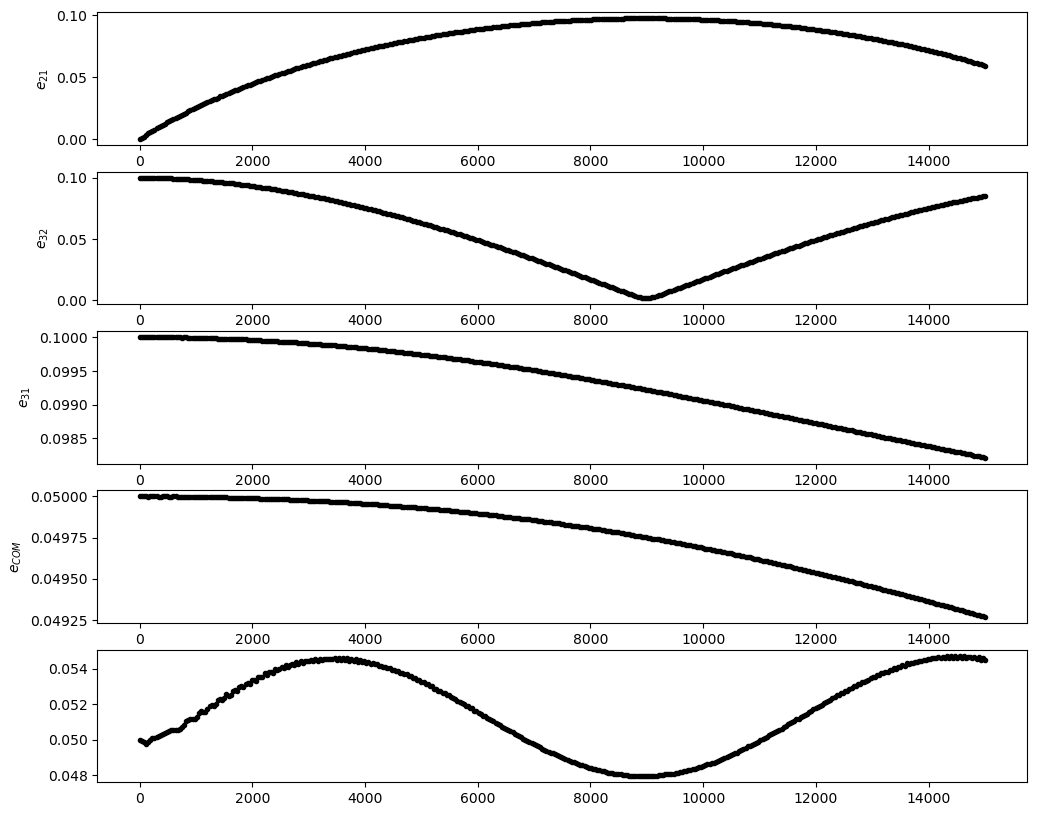

In [80]:
sim(0.05*0.78, 0.05*1.3, 1e-7, 1e-7, (0.05,0.05,0.05),(0,0,np.pi), 0.05*3e5)